In [1]:
# import libraries
import pandas as pd
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
#import sys
#!{sys.executable} -m pip install -U pip setuptools wheel
#!{sys.executable} -m pip install lifelines

In [3]:
#import sys
#!{sys.executable} -m pip install lifetimes


# 0. Read + Clean + Split

## 0.1 Read Data

In [4]:
df_raw = pd.read_csv("clv_input_V_FactStays_data_2025-06-04.csv", parse_dates=['Arrival Date'])

/tmp/ipykernel_1524/1990883790.py:1: DtypeWarning: Columns (4,6,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("clv_input_V_FactStays_data_2025-06-04.csv", parse_dates=['Arrival Date'])


In [5]:
# Display the first few rows of data_0
display(df_raw.head())

# List all column names, 5 per row
cols = list(df_raw.columns)
for i in range(0, len(cols), 5):
    print(', '.join(cols[i:i+5]))

,ParentCompanyID,PropertyID,CustomerID,StayID,CampaignID,SourceID,SendDate,GenderCode,City,State,Prefecture,CountryCode,Languages,Nationality,VIPCode,Domain Name,Email Status,Profile Type Code,Age,First Name,Last Name,Address,Email,Phone Number,Home Phone Number,Business Phone Number,Cell Phone Number,Loyalty,Exclude No Persons No Revenue,With Kids,Business,Repeat New,Stay Status,Arrival Date,Departure Date,Booking Date,Cancel Date,Channel,Source Of Business,Market Seg,Market Sub Seg,Room Nights,Num Adults,Num Children,Total Persons,Rate Type,Room Code,Room Type Code,Lead Time Days,IATA,Num Rooms,Currency Code,Room Revenue USD,Tax USD,Other Revenue USD,Total Revenue USD,Total Revenue With Tax USD,Last Updated
0,659fffb42d813e0001ea2cd7,65a66736df8b600001675726,65a8189a596ba80001bc98c4,65aeaf88596ba80001df4812,NaN,66cdd22677070300015d2541,NaN,NaN,NaN,NaN,NaN,US,EN,NaN,NaN,holualoa.com,Valid,I,NaN,Yes,Yes,No,Yes,Yes,No,No,Yes,NaN,No,Without,Leisure,New,C,2023-11-01,2023-11-30,2023-10-31,2023-11-01,NaN,PM,PM,PM,29,1,0,1,PM,PM,PM,1,NaN,1,USD,0.0,227.05,1711,1938.05,0.0,2025-03-07 20:39:25.9200000 +00:00
1,659fffb42d813e0001ea2cd7,65a66736df8b600001675726,65a8189e596ba80001bc98f4,65ae969046207b0001e31c18,NaN,67d44a639424fb59f4331312,NaN,Unknown,NaN,NaN,NaN,US,EN,NaN,NaN,civanacarefree.com,Valid,I,NaN,Yes,Yes,No,Yes,Yes,No,No,Yes,NaN,No,Without,Leisure,New,C,2023-06-01,2023-06-30,2023-05-31,2023-06-01,DCI,PM,PM,PM,29,1,0,1,PM,PM,PM,1,NaN,1,USD,0.0,227.05,1711,1938.05,0.0,2025-03-07 20:39:04.7666667 +00:00
2,659fffb42d813e0001ea2cd7,65a66736df8b600001675726,65a818b371a82c0001e20089,65aa6309596ba80001d0bd34,NaN,66cdd22677070300015d2541,NaN,NaN,Carefree,AZ,AZ,US,EN,NaN,NaN,gmail.com,Valid,I,NaN,Yes,Yes,Yes,Yes,Yes,No,No,Yes,NaN,No,Without,Leisure,Repeat,O,2023-05-07,2023-05-08,2023-04-29,NaN,NaN,LOCAL,COMP,COMP,1,2,0,2,COMP,Q2,Q2,8,NaN,1,USD,0.0,15.66,118,133.66,0.0,2025-03-07 20:39:03.1500000 +00:00
3,659fffb42d813e0001ea2cd7,65a66736df8b600001675726,65a818b571a82c0001e20097,65aeaae846207b0001e35d8f,NaN,66cdd22677070300015d2541,NaN,NaN,Atlanta,GA,GA,US,EN,NaN,VIP1,hexatlanta.com,Pending,I,NaN,Yes,Yes,Yes,Yes,Yes,No,No,Yes,NaN,No,Without,Leisure,Repeat,O,2023-10-02,2023-10-05,2023-10-02,NaN,NaN,EXEC,COMP,COMP,3,1,0,1,HOUSE,K1,K1,0,NaN,1,USD,0.0,23.49,177,200.49,0.0,2025-03-07 20:39:21.2666667 +00:00
4,659fffb42d813e0001ea2cd7,65a66736df8b600001675726,65a818b671a82c0001e200af,675479922a4714000142eca5,NaN,66cdd22677070300015d2541,NaN,Unknown,NaN,NaN,NaN,US,EN,NaN,NaN,civana.com,Pending,I,NaN,Yes,Yes,No,Yes,Yes,No,No,Yes,NaN,No,Without,Leisure,Repeat,O,2024-12-07,2024-12-07,2024-12-07,NaN,NaN,PM,PM,PM,0,1,0,1,PM,Q2P,Q2P,0,NaN,1,USD,0.0,0.00,0,0.00,0.0,2025-03-12 18:48:46.9500000 +00:00


ParentCompanyID, PropertyID, CustomerID, StayID, CampaignID
SourceID, SendDate, GenderCode, City, State
Prefecture, CountryCode, Languages, Nationality, VIPCode
Domain Name, Email Status, Profile Type Code, Age, First Name
Last Name, Address, Email, Phone Number, Home Phone Number
Business Phone Number, Cell Phone Number, Loyalty, Exclude No Persons No Revenue, With Kids
Business, Repeat New, Stay Status, Arrival Date, Departure Date
Booking Date, Cancel Date, Channel, Source Of Business, Market Seg
Market Sub Seg, Room Nights, Num Adults, Num Children, Total Persons
Rate Type, Room Code, Room Type Code, Lead Time Days, IATA
Num Rooms, Currency Code, Room Revenue USD, Tax USD, Other Revenue USD
Total Revenue USD, Total Revenue With Tax USD, Last Updated


In [6]:
# Count total CustomerID occurrences (including duplicates)
total_customerid_count = df_raw['CustomerID'].count()

# Count distinct CustomerIDs
distinct_customerid_count = df_raw['CustomerID'].nunique()

print(f"Total CustomerID count: {total_customerid_count}")
print(f"Distinct CustomerID count: {distinct_customerid_count}")

Total CustomerID count: 32776
Distinct CustomerID count: 27442


In [7]:
min_date = df_raw['Arrival Date'].min()
max_date = df_raw['Arrival Date'].max()
print(f"Min Arrival Date: {min_date}")
print(f"Max Arrival Date: {max_date}")

Min Arrival Date: 2023-01-02 00:00:00
Max Arrival Date: 2026-04-12 00:00:00


This means the data is transcation level

<span style="color: red;"> 

### input snapshot_date

</span>

In [8]:
snapshot_date = pd.to_datetime('2025-06-04')  # defines when the data was taken

In [9]:
df_txn_cumulative = df_raw[['CustomerID', 'Arrival Date', 'Total Revenue USD', 'Channel', 'Source Of Business', 'Market Seg', 'Market Sub Seg']].copy() # df_txn - transaction-level data

In [10]:
for col in ['Channel', 'Source Of Business', 'Market Seg', 'Market Sub Seg']:
    print(f"Distinct values for '{col}':")
    print(df_txn_cumulative[col].dropna().unique())
    print('-' * 40)

Distinct values for 'Channel':
['DCI' 'WEB' 'RL' 'SYDC' 'WI' 'CRS' 'HOUSE' 'GCI' 'EMAIL' 'GDS' 'PMS'
 'SAL' 'CHOPRA' 'MARKETING' 'INTERNET' 'GOOG' 'IDS']
----------------------------------------
Distinct values for 'Source Of Business':
['PM' 'LOCAL' 'EXEC' 'XBE' 'RPTGRP' 'THIRD' 'MARKETING' 'FABIO' 'WALK'
 'FIXME' 'INTERNET' 'EXPDC' 'RPT' 'SALES' 'WEB' 'TRAVAG' 'ASSOCREF' 'NGVA'
 'INSTAGRAM' 'CVENT' 'AMBASSADOR' 'SPA' 'UA' 'REF' 'CLIEREF' 'VENDOR'
 'PROGRAM' 'CHOPRA' 'F&B' 'SKALLA' 'AA' 'RESPASS' 'GOOGLE' 'FACEBOOK.'
 'MPI' 'TVA' 'OUTSLS' 'GIF' 'PHNSOL' 'FIT' 'OTHR' 'YOGASIX' 'TEACHER' 'AD'
 'USA' '1P' 'GPRMLIST' 'HPN' 'MOBILE' '1A' 'IDS' 'HELMS']
----------------------------------------
Distinct values for 'Market Seg':
['PM' 'COMP' 'DPRO' 'GCOR' 'PKG' 'OBAR' 'CCO' 'BAR' 'QDS' 'AP' 'DAY'
 'GSME' 'GOT' 'GSWR' 'GCWR' 'OPQ' 'OPRO' 'GTOU' 'GCES' 'AMB' 'GASA' 'WHO'
 'CON' 'HSE' 'CREW']
----------------------------------------
Distinct values for 'Market Sub Seg':
['PM' 'COMP' 'DPRO' 'GCOR

In [11]:
# Make sure Arrival Date is in datetime format
df_txn_cumulative['Arrival Date'] = pd.to_datetime(df_txn_cumulative['Arrival Date'])

# Sort by Customer ID and Arrival Date
df_txn_cumulative = df_txn_cumulative.sort_values(['CustomerID', 'Arrival Date'])

# Calculate total revenue per visit 
df_txn_cumulative['Total Revenue USD'] = df_txn_cumulative['Total Revenue USD']

### this code block exit because:
    # df_txn_cumulative is cumulative
    # df_txn is not cumulative

df_txn = df_txn_cumulative

In [12]:
df_txn = df_txn_cumulative.iloc[:, :4].copy()

In [13]:
df_txn.head()

,CustomerID,Arrival Date,Total Revenue USD,Channel
2740,65a8189a596ba80001bc98c4,2023-01-11,706.80,NaN
2735,65a8189a596ba80001bc98c4,2023-02-01,1804.39,NaN
2738,65a8189a596ba80001bc98c4,2023-02-18,66.83,NaN
2749,65a8189a596ba80001bc98c4,2023-03-01,2004.88,NaN
2736,65a8189a596ba80001bc98c4,2023-04-01,1938.05,NaN


In [14]:
df_txn.shape[0]

32776

## 0.2 Clean Data

In [15]:
df_txn = df_txn[
    (df_txn['Arrival Date'] < snapshot_date) &  # already happened
    (df_txn['Total Revenue USD'] > 0)                # total revnue is positive
].copy()

In [16]:
df_txn.shape[0]

30362

In [17]:
# Create a discrete frequency table for Channel
channel_table = df_txn.groupby('Channel').agg(
    total_customerid_count=('CustomerID', 'count'),
    distinct_customerid_count=('CustomerID', 'nunique'),
    avg_total_revenue_usd=('Total Revenue USD', lambda x: int(x.sum() / len(x)))
).reset_index()

# display(channel_table)

In [18]:
# Sort channel_table by total_customerid_count in descending order
channel_table_sorted = channel_table.sort_values(by='total_customerid_count', ascending=False).reset_index(drop=True)
display(channel_table_sorted)

,Channel,total_customerid_count,distinct_customerid_count,avg_total_revenue_usd
0,WEB,15725,13813,2195
1,SYDC,4232,3877,1820
2,RL,3118,2776,2235
3,CRS,397,355,2174
4,GDS,208,202,1966
5,DCI,155,117,2210
6,CHOPRA,123,117,3326
7,SAL,101,89,1437
8,INTERNET,95,69,1978
9,EMAIL,87,81,1297


### Base on above table, here is the grouping table

| Group         | Included Channels                                | Rationale                                       |
| ------------- | ------------------------------------------------ | ----------------------------------------------- |
| **WEB**       | `WEB`                                            | Dominant volume (15K+ rows), baseline           |
| **OTA/GDS**   | `GDS`, `CRS`, `INTERNET`, `GOOG`, `EMAIL`, `IDS` | Online/travel agents & digital booking channels |
| **Direct**    | `RL`, `PMS`, `DCI`, `WI`, `HOUSE`, `SAL`         | Internal or direct contact methods              |
| **Corporate** | `SYDC`, `GCI`, `MARKETING`                       | Likely B2B or corporate-coded traffic           |
| **Specialty** | `CHOPRA`                                         | High-value niche (highest avg revenue)          |
| **Unknown**   | `Unknown`                                        | For missing or unclassified values              |


In [19]:
def categorize_channel(ch):
    if ch == 'WEB':
        return 'WEB'
    elif ch in ['GDS', 'CRS', 'INTERNET', 'GOOG', 'EMAIL', 'IDS']:
        return 'OTA/GDS'
    elif ch in ['RL', 'PMS', 'DCI', 'WI', 'HOUSE', 'SAL']:
        return 'Direct'
    elif ch in ['SYDC', 'GCI', 'MARKETING']:
        return 'Corporate'
    elif ch == 'CHOPRA':
        return 'Specialty'
    else:
        return 'Unknown'

df_txn['Channel_Group'] = df_txn['Channel'].fillna('Unknown').apply(categorize_channel)


In [20]:
# Replace NaN with a placeholder (e.g., 'Unknown')
df_txn['Channel_Group'] = df_txn['Channel_Group'].fillna('Unknown')

# One-hot encode, keep all columns
channel_dummies = pd.get_dummies(df_txn['Channel_Group'], prefix='Channel', drop_first=False)

# Combine with original df_txn
df_txn_encoded = pd.concat([df_txn, channel_dummies], axis=1)

# When modeling, drop 'Channel_WEB' to use WEB as the baseline
# Example: features = [col for col in channel_dummies.columns if col != 'Channel_WEB']

In [21]:
df_txn_encoded.head()

,CustomerID,Arrival Date,Total Revenue USD,Channel,Channel_Group,Channel_Corporate,Channel_Direct,Channel_OTA/GDS,Channel_Specialty,Channel_Unknown,Channel_WEB
2740,65a8189a596ba80001bc98c4,2023-01-11,706.80,NaN,Unknown,False,False,False,False,True,False
2735,65a8189a596ba80001bc98c4,2023-02-01,1804.39,NaN,Unknown,False,False,False,False,True,False
2738,65a8189a596ba80001bc98c4,2023-02-18,66.83,NaN,Unknown,False,False,False,False,True,False
2749,65a8189a596ba80001bc98c4,2023-03-01,2004.88,NaN,Unknown,False,False,False,False,True,False
2736,65a8189a596ba80001bc98c4,2023-04-01,1938.05,NaN,Unknown,False,False,False,False,True,False


In [22]:
# Create a discrete frequency table for Channel
channel_table_2 = df_txn.groupby('Channel_Group').agg(
    total_customerid_count=('CustomerID', 'count'),
    distinct_customerid_count=('CustomerID', 'nunique'),
    avg_total_revenue_usd=('Total Revenue USD', lambda x: int(x.sum() / len(x)))
).reset_index()

# Sort df_txn_encoded by total_customerid_count in descending order
channel_table_encoded_sorted_2 = channel_table_2.sort_values(by='total_customerid_count', ascending=False).reset_index(drop=True)
display(channel_table_encoded_sorted_2)

,Channel_Group,total_customerid_count,distinct_customerid_count,avg_total_revenue_usd
0,WEB,15725,13813,2195
1,Unknown,5973,4780,1689
2,Corporate,4293,3918,1805
3,Direct,3459,3041,2209
4,OTA/GDS,789,708,1999
5,Specialty,123,117,3326


## 0.3 Split data

The current data is one **visit** per row

There are 4 algos next:

| Algo                              | Table Format              |
|-----------------------------------|---------------------------|
| Current method - RFM              | one **visit** per row     |
| OneTimers - Survival Analysis     | one **customer** per row  |
| Repeaters - BG/NBD                | one **visit** per row     |
| Repeaters - Gamma-Gamma           | one **visit** per row     |


In [23]:
distinct_customer_count = df_txn_encoded['CustomerID'].nunique()
print(f"Distinct customer count: {distinct_customer_count}")

Distinct customer count: 25516


In [24]:
repeat_counts = df_txn_encoded['CustomerID'].value_counts()
df_txn_encoded['repeat'] = df_txn_encoded['CustomerID'].map(lambda x: 'Y' if repeat_counts[x] > 1 else 'N')
df_txn_encoded.head()

,CustomerID,Arrival Date,Total Revenue USD,Channel,Channel_Group,Channel_Corporate,Channel_Direct,Channel_OTA/GDS,Channel_Specialty,Channel_Unknown,Channel_WEB,repeat
2740,65a8189a596ba80001bc98c4,2023-01-11,706.80,NaN,Unknown,False,False,False,False,True,False,Y
2735,65a8189a596ba80001bc98c4,2023-02-01,1804.39,NaN,Unknown,False,False,False,False,True,False,Y
2738,65a8189a596ba80001bc98c4,2023-02-18,66.83,NaN,Unknown,False,False,False,False,True,False,Y
2749,65a8189a596ba80001bc98c4,2023-03-01,2004.88,NaN,Unknown,False,False,False,False,True,False,Y
2736,65a8189a596ba80001bc98c4,2023-04-01,1938.05,NaN,Unknown,False,False,False,False,True,False,Y


In [25]:
# Create a discrete frequency table for the 'repeat' column
repeat_table = df_txn_encoded['repeat'].value_counts().reset_index()
repeat_table.columns = ['repeat', 'count']
repeat_table['percent'] = (repeat_table['count'] / repeat_table['count'].sum() * 100).round(2)
display(repeat_table)

,repeat,count,percent
0,N,22594,74.42
1,Y,7768,25.58


In [26]:
22594 + 7768

30362

In [27]:
repeat_distinct_count = df_txn_encoded.groupby('repeat')['CustomerID'].nunique().reset_index()
repeat_distinct_count.columns = ['repeat', 'distinct_customer_count']
display(repeat_distinct_count)

,repeat,distinct_customer_count
0,N,22594
1,Y,2922


In [28]:
22594 + 2922

25516

In [29]:
df_txn_encoded.head()

,CustomerID,Arrival Date,Total Revenue USD,Channel,Channel_Group,Channel_Corporate,Channel_Direct,Channel_OTA/GDS,Channel_Specialty,Channel_Unknown,Channel_WEB,repeat
2740,65a8189a596ba80001bc98c4,2023-01-11,706.80,NaN,Unknown,False,False,False,False,True,False,Y
2735,65a8189a596ba80001bc98c4,2023-02-01,1804.39,NaN,Unknown,False,False,False,False,True,False,Y
2738,65a8189a596ba80001bc98c4,2023-02-18,66.83,NaN,Unknown,False,False,False,False,True,False,Y
2749,65a8189a596ba80001bc98c4,2023-03-01,2004.88,NaN,Unknown,False,False,False,False,True,False,Y
2736,65a8189a596ba80001bc98c4,2023-04-01,1938.05,NaN,Unknown,False,False,False,False,True,False,Y


In [30]:
# Filter to repeaters only
repeaters_txn = df_txn_encoded[df_txn_encoded['repeat'] == 'Y'].copy()

# Assign visit number per customer (sorted by Arrival Date)
repeaters_txn['visit_number'] = repeaters_txn.sort_values(['CustomerID', 'Arrival Date']) \
    .groupby('CustomerID').cumcount() + 1

# Calculate average spending for each visit number across all repeaters
avg_spend_per_visit = repeaters_txn.groupby('visit_number')['Total Revenue USD'].mean().reset_index()
avg_spend_per_visit.columns = ['visit_number', 'avg_spend']

display(avg_spend_per_visit)

,visit_number,avg_spend
0,1,2042.850664
1,2,2076.461492
2,3,1937.836895
3,4,1793.822672
4,5,1555.180261
...,...,...
127,128,371.810000
128,129,836.610000
129,130,700.010000
130,131,5265.970000


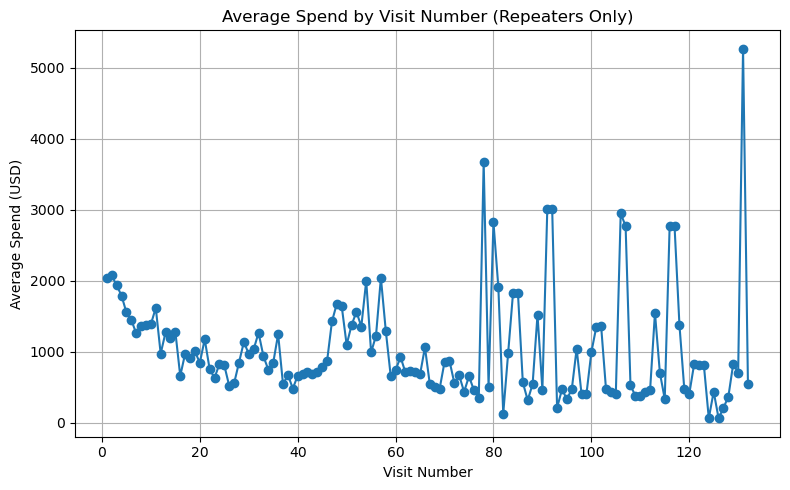

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(avg_spend_per_visit['visit_number'], avg_spend_per_visit['avg_spend'], marker='o')
plt.xlabel('Visit Number')
plt.ylabel('Average Spend (USD)')
plt.title('Average Spend by Visit Number (Repeaters Only)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 0.4 Total (25516) = OneTimer (22594) + Repeater (2922)

# 1. Current RFM Method (25516)

RFM - one **visit** per row 

In [32]:
df_rfm = df_txn.groupby('CustomerID').agg({
    'Arrival Date': lambda x: (snapshot_date - x.max()).days,  # Recency
    'CustomerID': 'count',                                     # Frequency
    'Total Revenue USD': 'sum'                                 # Monetary
}).rename(columns={
    'Arrival Date': 'Recency',
    'CustomerID': 'Frequency',
    'Total Revenue USD': 'Monetary'
}).reset_index()


In [33]:
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,65a8189a596ba80001bc98c4,307,19,26495.09
1,65a8189e596ba80001bc98f4,429,18,31743.93
2,65a818b371a82c0001e20089,254,23,9117.01
3,65a818b571a82c0001e20097,66,44,10823.91
4,65a818b671a82c0001e200af,429,14,25528.80


RFM Score ranges from 3 to 15

- Each of R, F, M ranges from 1 to 5

- 3 = worst (R=1, F=1, M=1)

- 15 = best (R=5, F=5, M=5)

In [34]:
# Recency: lower is better → reverse the score
df_rfm['R_Score'] = pd.qcut(df_rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)

# Frequency: higher is better
df_rfm['F_Score'] = pd.qcut(df_rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Monetary: higher is better
df_rfm['M_Score'] = pd.qcut(df_rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Combine to get RFM segment code (e.g., 555 is best, 111 is worst)
df_rfm['RFM_Segment'] = df_rfm['R_Score'].astype(str) + df_rfm['F_Score'].astype(str) + df_rfm['M_Score'].astype(str)

# Optionally create a single score (e.g., sum of scores)
df_rfm['RFM_Score'] = df_rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)


| RFM Score Range | Segment Name            | Description                         |
|-----------------|-------------------------|-------------------------------------|
| 13–15           | **Champions**           | Recent, frequent, and high spenders |
| 10–12           | **Loyal Customers**     | Frequent and/or high spenders       |
| 7–9             | **Potential Loyalists** | May become loyal with encouragement |
| 4–6             | **At Risk**             | Haven’t returned recently           |
| 3               | **Lost**                | Long gone, low value                |


In [35]:
# Segment assignment
def assign_rfm_segment(score):
    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal Customers'
    elif score >= 7:
        return 'Potential Loyalists'
    elif score >= 4:
        return 'At Risk'
    else:
        return 'Lost'

df_rfm['Segment'] = df_rfm['RFM_Score'].apply(assign_rfm_segment)

df_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
0,65a8189a596ba80001bc98c4,307,19,26495.09,4,5,5,455,14,Champions
1,65a8189e596ba80001bc98f4,429,18,31743.93,3,5,5,355,13,Champions
2,65a818b371a82c0001e20089,254,23,9117.01,4,5,5,455,14,Champions
3,65a818b571a82c0001e20097,66,44,10823.91,5,5,5,555,15,Champions
4,65a818b671a82c0001e200af,429,14,25528.80,3,5,5,355,13,Champions


In [36]:
df_rfm.shape[0]

25516

# 2. CLV For OneTimer (22594)

survival analysis - one **customer** per row 

## 2.1 Aggregate to One Row per Customer

In [37]:
df_txn_encoded.head()

,CustomerID,Arrival Date,Total Revenue USD,Channel,Channel_Group,Channel_Corporate,Channel_Direct,Channel_OTA/GDS,Channel_Specialty,Channel_Unknown,Channel_WEB,repeat
2740,65a8189a596ba80001bc98c4,2023-01-11,706.80,NaN,Unknown,False,False,False,False,True,False,Y
2735,65a8189a596ba80001bc98c4,2023-02-01,1804.39,NaN,Unknown,False,False,False,False,True,False,Y
2738,65a8189a596ba80001bc98c4,2023-02-18,66.83,NaN,Unknown,False,False,False,False,True,False,Y
2749,65a8189a596ba80001bc98c4,2023-03-01,2004.88,NaN,Unknown,False,False,False,False,True,False,Y
2736,65a8189a596ba80001bc98c4,2023-04-01,1938.05,NaN,Unknown,False,False,False,False,True,False,Y


In [38]:
# Make sure 'Arrival Date' is datetime
df_txn_encoded['Arrival Date'] = pd.to_datetime(df_txn_encoded['Arrival Date'])

# Group by customer
df_cust = df_txn_encoded.groupby('CustomerID').agg({
    'Arrival Date': ['min', 'max', 'count'],
    'Total Revenue USD': 'mean'  # average spend per visit
}).reset_index()

# Rename columns
df_cust.columns = ['CustomerID', 'first_date', 'last_date', 'visit_count', 'avg_spend']

# Duration = time between first visit and snapshot
df_cust['duration'] = (snapshot_date - df_cust['first_date']).dt.days

# Event = 1 if they had more than one visit
df_cust['event'] = (df_cust['visit_count'] > 1).astype(int)

channel_dummies = ['Channel_Corporate', 'Channel_Direct', 'Channel_OTA/GDS', 'Channel_Specialty', 'Channel_Unknown', 'Channel_WEB']
df_channels = df_txn_encoded[['CustomerID'] + channel_dummies].drop_duplicates('CustomerID')

df_cust = df_cust.merge(df_channels, on='CustomerID', how='left')

In [39]:
df_cust.head()

,CustomerID,first_date,last_date,visit_count,avg_spend,duration,event,Channel_Corporate,Channel_Direct,Channel_OTA/GDS,Channel_Specialty,Channel_Unknown,Channel_WEB
0,65a8189a596ba80001bc98c4,2023-01-11,2024-08-01,19,1394.478421,875,1,False,False,False,False,True,False
1,65a8189e596ba80001bc98f4,2023-02-01,2024-04-01,18,1763.551667,854,1,False,True,False,False,False,False
2,65a818b371a82c0001e20089,2023-01-16,2024-09-23,23,396.391739,870,1,False,False,False,False,True,False
3,65a818b571a82c0001e20097,2023-01-17,2025-03-30,44,245.997955,869,1,False,False,False,False,True,False
4,65a818b671a82c0001e200af,2023-02-01,2024-04-01,14,1823.485714,854,1,False,False,False,False,True,False


## 2.2 Fit Cox Proportional Hazards Model

In [40]:
from lifelines import CoxPHFitter

df_model = df_cust[['duration', 'event', 'avg_spend']].dropna()

cph = CoxPHFitter()
cph.fit(df_model, duration_col='duration', event_col='event')

<lifelines.CoxPHFitter: fitted with 25516 total observations, 22594 right-censored observations>

## 2.3 Predict Return Probability for One-Timers @ xdays - horizon

<span style="color: red;"> 

### define xdays 

</span>

In [41]:
xdays = 365  # change to any day horizon you want



# Filter one-timers
df_onetimers = df_cust[df_cust['visit_count'] == 1].copy()

# Predict survival probability at xdays
surv_probs = cph.predict_survival_function(df_onetimers, times=[xdays]).T

# Add predicted return probability to df
df_onetimers['P_return'] = 1 - surv_probs[xdays].values

# Calculate CLV
df_onetimers['CLV'] = df_onetimers['P_return'] * df_onetimers['avg_spend']


df_onetimers.head()

In [42]:
from lifelines import CoxPHFitter

channel_cols = [
    'Channel_Corporate',
    'Channel_Direct',
    'Channel_OTA/GDS',
    'Channel_Specialty',
    'Channel_Unknown',
    'Channel_WEB'
]

# Store models and predictions
models = {}
results = []

for col in channel_cols:
    print(f"Fitting model for: {col}")

    # Subset data where this channel == True
    df_sub = df_cust[df_cust[col] == True].copy()

    # Drop rows with missing data
    df_sub = df_sub[['duration', 'event', 'avg_spend']].dropna()

    if len(df_sub) < 100:
        print(f"⚠️ Skipping {col}, not enough data ({len(df_sub)} rows)")
        continue

    # Fit Cox model
    cph = CoxPHFitter()
    cph.fit(df_sub, duration_col='duration', event_col='event')

    # Store model
    models[col] = cph

    # Predict for that group (only one-timers in that group)
    df_pred = df_cust[(df_cust[col] == True) & (df_cust['visit_count'] == 1)].copy()

    surv_probs = cph.predict_survival_function(df_pred, times=[xdays]).T
    df_pred['P_return'] = 1 - surv_probs[xdays].values
    df_pred['CLV'] = df_pred['P_return'] * df_pred['avg_spend']
    df_pred['Channel_Group'] = col

    results.append(df_pred)

# Combine all predictions
df_onetimer_results = pd.concat(results, ignore_index=True)


Fitting model for: Channel_Corporate
Fitting model for: Channel_Direct
Fitting model for: Channel_OTA/GDS
Fitting model for: Channel_Specialty
Fitting model for: Channel_Unknown
Fitting model for: Channel_WEB


In [43]:
df_onetimer_results.head()

,CustomerID,first_date,last_date,visit_count,avg_spend,duration,event,Channel_Corporate,Channel_Direct,Channel_OTA/GDS,Channel_Specialty,Channel_Unknown,Channel_WEB,P_return,CLV,Channel_Group
0,65a819e6596ba80001bc9b33,2024-04-27,2024-04-27,1,3237.26,403,0,True,False,False,False,False,False,0.044378,143.662529,Channel_Corporate
1,65a835dd596ba80001bd3771,2023-11-22,2023-11-22,1,2076.58,560,0,True,False,False,False,False,False,0.041794,86.788698,Channel_Corporate
2,65a852e171a82c0001e2a853,2025-02-13,2025-02-13,1,2538.38,111,0,True,False,False,False,False,False,0.042804,108.652685,Channel_Corporate
3,65a91474596ba80001bfefa4,2024-09-28,2024-09-28,1,980.30,249,0,True,False,False,False,False,False,0.039489,38.711138,Channel_Corporate
4,65a91d75df8b6000016af04a,2023-08-17,2023-08-17,1,314.89,657,0,True,False,False,False,False,False,0.038151,12.013437,Channel_Corporate


In [44]:
df_onetimer_results.shape[0]

22594

# 3. CLV For Repeaters (2922)

BG/NBD - one **visit** per row  

Gamma-Gamma - one **visit** per row

## 3.1 filter repeaters

In [45]:
df_repeaters = df_cust[df_cust['visit_count'] > 1].copy() # this is 1 row per customer

# Count transactions per customer
visit_counts = df_txn['CustomerID'].value_counts()

# Get repeater IDs
repeater_ids = visit_counts[visit_counts > 1].index

# Filter visit-level data to just repeaters
df_repeat_txn = df_txn[df_txn['CustomerID'].isin(repeater_ids)].copy()

In [46]:
df_repeat_txn['CustomerID'].nunique()

2922

## 3.2 transction-level data

In [47]:
from lifetimes.utils import summary_data_from_transaction_data

summary_df = summary_data_from_transaction_data(
    df_repeat_txn,
    customer_id_col='CustomerID',
    datetime_col='Arrival Date',
    monetary_value_col='Total Revenue USD',
    observation_period_end=snapshot_date
)


In [48]:
snapshot_date

Timestamp('2025-06-04 00:00:00')

In [49]:
summary_df.shape[0]

2922

## 3.3 Fit BG/NBD Model (visit frequency)

In [50]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter()
bgf.fit(
    summary_df['frequency'],
    summary_df['recency'],
    summary_df['T']
)


<lifetimes.BetaGeoFitter: fitted with 2922 subjects, a: 0.90, alpha: 193.98, b: 0.36, r: 1.11>

## 3.4 Fit Gamma-Gamma Model (spending)

In [51]:
from lifetimes import GammaGammaFitter

# Filter to customers with monetary_value > 0 and frequency > 0
ggf_input = summary_df[(summary_df['monetary_value'] > 0) & (summary_df['frequency'] > 0)]

ggf = GammaGammaFitter()
ggf.fit(
    ggf_input['frequency'],
    ggf_input['monetary_value']
)


<lifetimes.GammaGammaFitter: fitted with 2307 subjects, p: 2.56, q: 4.01, v: 2588.05>

## 3.5 Predict CLV for repeaters @ xdays - horizon

In [52]:
summary_df['predicted_purchases_180d'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    xdays,
    summary_df['frequency'],
    summary_df['recency'],
    summary_df['T']
)

summary_df['expected_value'] = ggf.conditional_expected_average_profit(
    summary_df['frequency'],
    summary_df['monetary_value']
)

summary_df['CLV'] = summary_df['predicted_purchases_180d'] * summary_df['expected_value']


In [53]:
summary_df.head()

,frequency,recency,T,monetary_value,predicted_purchases_180d,expected_value,CLV
CustomerID,,,,,,,
65a8189a596ba80001bc98c4,18.0,568.0,875.0,1432.682778,0.164509,1479.808173,243.441731
65a8189e596ba80001bc98f4,13.0,425.0,854.0,2303.041538,0.034364,2294.603859,78.850905
65a818b371a82c0001e20089,22.0,616.0,870.0,405.296364,0.286629,496.406905,142.284512
65a818b571a82c0001e20097,42.0,803.0,869.0,252.938571,9.577645,305.993315,2930.695391
65a818b671a82c0001e200af,13.0,425.0,854.0,1824.954615,0.034364,1856.168051,63.784661


In [54]:
summary_df.shape[0]

2922

# 4. compare RFM vs CLV

## 4.1 combine onetimer and repeater for CLV

In [55]:
# For each CustomerID, get the latest (most recent) Channel from df_txn_encoded
latest_channel = (
    df_txn_encoded.sort_values(['CustomerID', 'Arrival Date'])
    .groupby('CustomerID')
    .tail(1)[['CustomerID', 'Channel', 'Channel_Group']]
    .reset_index(drop=True)
)

display(latest_channel.head())


,CustomerID,Channel,Channel_Group
0,65a8189a596ba80001bc98c4,NaN,Unknown
1,65a8189e596ba80001bc98f4,DCI,Direct
2,65a818b371a82c0001e20089,NaN,Unknown
3,65a818b571a82c0001e20097,NaN,Unknown
4,65a818b671a82c0001e200af,NaN,Unknown


In [56]:
latest_channel.shape[0]

25516

In [57]:
df_onetimers_clv = df_onetimer_results[['CustomerID', 'CLV']]

summary_df = summary_df.reset_index()
df_repeaters_clv = summary_df[['CustomerID', 'CLV']]

df_onetimers_clv['group'] = 'onetimer'
df_repeaters_clv['group'] = 'repeater'

df_all_clv = pd.concat([df_onetimers_clv, df_repeaters_clv], axis=0).reset_index(drop=True)

In [58]:
df_all_clv = df_all_clv.merge(latest_channel, on='CustomerID', how='left')

In [59]:
# join latest_channel and df_all_clv
df_all_clv = df_all_clv.merge(latest_channel, on='CustomerID', how='left')

In [60]:
df_all_clv.head()

,CustomerID,CLV,group,Channel_x,Channel_Group_x,Channel_y,Channel_Group_y
0,65a819e6596ba80001bc9b33,143.662529,onetimer,SYDC,Corporate,SYDC,Corporate
1,65a835dd596ba80001bd3771,86.788698,onetimer,SYDC,Corporate,SYDC,Corporate
2,65a852e171a82c0001e2a853,108.652685,onetimer,SYDC,Corporate,SYDC,Corporate
3,65a91474596ba80001bfefa4,38.711138,onetimer,SYDC,Corporate,SYDC,Corporate
4,65a91d75df8b6000016af04a,12.013437,onetimer,GCI,Corporate,GCI,Corporate


In [61]:
df_all_clv.shape[0] 

25516

## 4.2 join with RFM data 

In [62]:
# e.g. Add visit count or RFM scores if needed
df_all_clv = df_all_clv.merge(df_rfm[['CustomerID', 'RFM_Score', 'Segment']], on='CustomerID', how='left')

In [63]:
df_all_clv.head()

,CustomerID,CLV,group,Channel_x,Channel_Group_x,Channel_y,Channel_Group_y,RFM_Score,Segment
0,65a819e6596ba80001bc9b33,143.662529,onetimer,SYDC,Corporate,SYDC,Corporate,9,Potential Loyalists
1,65a835dd596ba80001bd3771,86.788698,onetimer,SYDC,Corporate,SYDC,Corporate,6,At Risk
2,65a852e171a82c0001e2a853,108.652685,onetimer,SYDC,Corporate,SYDC,Corporate,10,Loyal Customers
3,65a91474596ba80001bfefa4,38.711138,onetimer,SYDC,Corporate,SYDC,Corporate,6,At Risk
4,65a91d75df8b6000016af04a,12.013437,onetimer,GCI,Corporate,GCI,Corporate,4,At Risk


## 4.3 Plotting CLV distributions

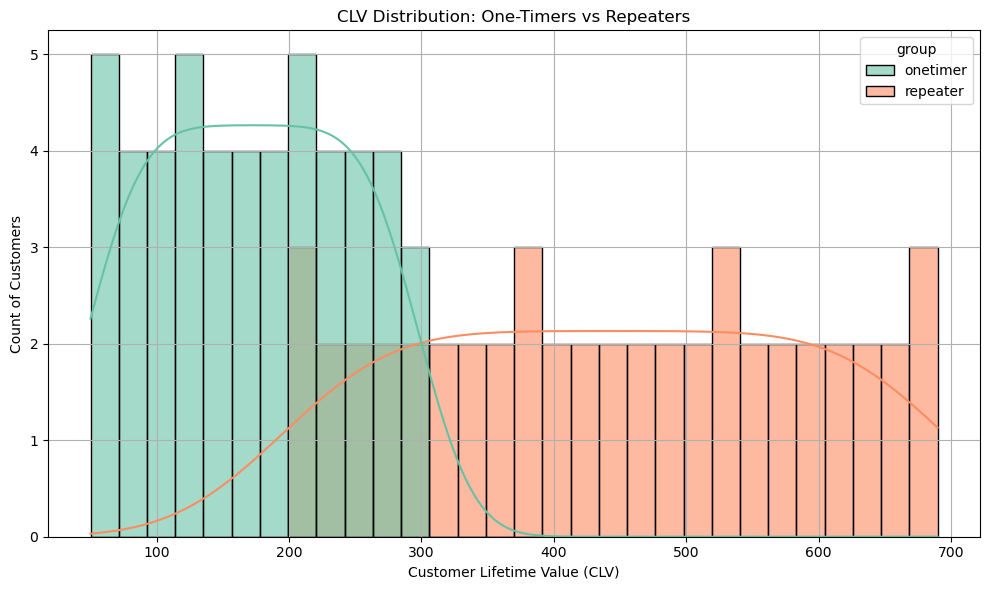

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# create simulated combined CLV data
data = {
    'CustomerID': [f'C{i}' for i in range(1, 101)],
    'CLV': [50 + i * 5 for i in range(50)] + [200 + i * 10 for i in range(50)],
    'group': ['onetimer'] * 50 + ['repeater'] * 50
}
df_all_clv_1 = pd.DataFrame(data)

# Plotting CLV distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_all_clv_1, x='CLV', hue='group', bins=30, kde=True, palette='Set2', alpha=0.6)
plt.title('CLV Distribution: One-Timers vs Repeaters')
plt.xlabel('Customer Lifetime Value (CLV)')
plt.ylabel('Count of Customers')
plt.grid(True)
plt.tight_layout()
plt.show()


In [65]:
df_all_clv_1.head()

,CustomerID,CLV,group
0,C1,50,onetimer
1,C2,55,onetimer
2,C3,60,onetimer
3,C4,65,onetimer
4,C5,70,onetimer


Histogram with kernel density curves (smooth lines) comparing the Customer Lifetime Value (CLV) distributions

Each bar (or bin) shows how many customers fall within a certain CLV range.

One-timers tend to have lower CLVs, as expected.
- Typically peaks at lower CLV — they’re less likely to return, so lower value.

Repeaters show a wider and higher CLV range due to more frequent and valuable returns.
- Spreads out higher — they’re more likely to come back and spend more.

## 4.4 Compare RFM vs CLV

In [66]:
# Segmented CLV into quartiles for meaningful comparison.
# Safe quantile binning
df_all_clv['CLV_Level'] = pd.qcut(
    df_all_clv['CLV'],
    q=4,
    labels=['Low', 'Mid', 'High', 'Top']
)

In [67]:
df_all_clv.head()

,CustomerID,CLV,group,Channel_x,Channel_Group_x,Channel_y,Channel_Group_y,RFM_Score,Segment,CLV_Level
0,65a819e6596ba80001bc9b33,143.662529,onetimer,SYDC,Corporate,SYDC,Corporate,9,Potential Loyalists,Top
1,65a835dd596ba80001bd3771,86.788698,onetimer,SYDC,Corporate,SYDC,Corporate,6,At Risk,High
2,65a852e171a82c0001e2a853,108.652685,onetimer,SYDC,Corporate,SYDC,Corporate,10,Loyal Customers,High
3,65a91474596ba80001bfefa4,38.711138,onetimer,SYDC,Corporate,SYDC,Corporate,6,At Risk,Mid
4,65a91d75df8b6000016af04a,12.013437,onetimer,GCI,Corporate,GCI,Corporate,4,At Risk,Low


In [68]:
df_all_clv.shape[0] 

25516

In [69]:
# add mismatch label
df_all_clv['Mismatch'] = df_all_clv.apply(
    lambda x: 'Overrated (High RFM, Low CLV)'
        if x['Segment'] in ['Champions', 'Loyal Customers'] and x['CLV_Level'] == 'Low'
    else 'Underrated (Low RFM, High CLV)'
        if x['Segment'] in ['At Risk', 'Lost'] and x['CLV_Level'] in ['High', 'Top']
    else 'Aligned',
    axis=1
)

In [70]:
# Quantified the gap
df_all_clv['Mismatch'].value_counts()

Mismatch
Aligned                           22902
Underrated (Low RFM, High CLV)     1327
Overrated (High RFM, Low CLV)      1287
Name: count, dtype: int64

In [71]:
22924+1325+1267

25516

| Mismatch Category                  | Interpretation                                                                                  |
| ---------------------------------- | ----------------------------------------------------------------------------------------------- |
| **Aligned**                        | Most customers are in sync — RFM and CLV agree                                                  |
| **Overrated (High RFM, Low CLV)**  | These customers *look valuable* by RFM, but your model says **they won’t return or spend much** |
| **Underrated (Low RFM, High CLV)** | These customers *look quiet* historically, but **your model sees future value**                 |


## 4.5 visualize the mismatch

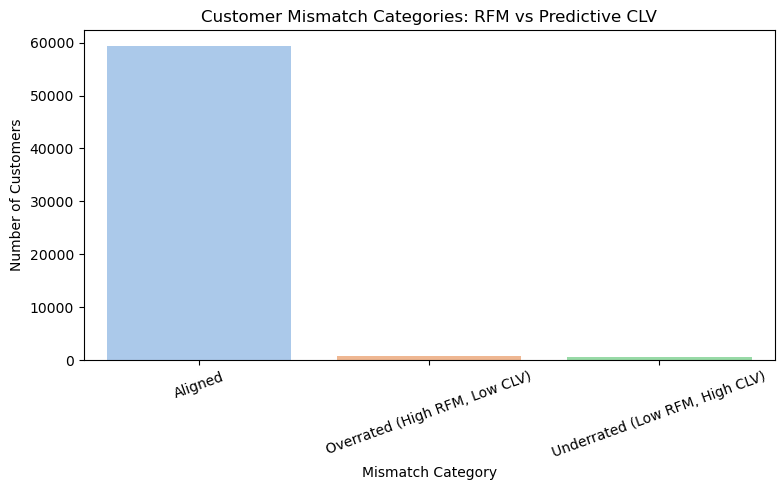

In [72]:
# Re-import libraries and reload data after reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Re-create the nonzero_df (only structure, not full pipeline due to reset)
# Simulating a sample dataframe for plotting
sample_data = {
    'Mismatch': ['Aligned'] * 59354 + 
                ['Overrated (High RFM, Low CLV)'] * 877 + 
                ['Underrated (Low RFM, High CLV)'] * 665
}
nonzero_df = pd.DataFrame(sample_data)

# Plot
plt.figure(figsize=(8, 5))
sns.countplot(data=nonzero_df, x='Mismatch', order=nonzero_df['Mismatch'].value_counts().index, palette='pastel')
plt.title("Customer Mismatch Categories: RFM vs Predictive CLV")
plt.xlabel("Mismatch Category")
plt.ylabel("Number of Customers")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


## 4.6 export all output

In [73]:
df_all_clv.head()

,CustomerID,CLV,group,Channel_x,Channel_Group_x,Channel_y,Channel_Group_y,RFM_Score,Segment,CLV_Level,Mismatch
0,65a819e6596ba80001bc9b33,143.662529,onetimer,SYDC,Corporate,SYDC,Corporate,9,Potential Loyalists,Top,Aligned
1,65a835dd596ba80001bd3771,86.788698,onetimer,SYDC,Corporate,SYDC,Corporate,6,At Risk,High,"Underrated (Low RFM, High CLV)"
2,65a852e171a82c0001e2a853,108.652685,onetimer,SYDC,Corporate,SYDC,Corporate,10,Loyal Customers,High,Aligned
3,65a91474596ba80001bfefa4,38.711138,onetimer,SYDC,Corporate,SYDC,Corporate,6,At Risk,Mid,Aligned
4,65a91d75df8b6000016af04a,12.013437,onetimer,GCI,Corporate,GCI,Corporate,4,At Risk,Low,Aligned


In [74]:
df_all_clv[['CustomerID',  'group', 'Channel_x', 'Channel_Group_x', 'RFM_Score', 'Segment', 'CLV', 'CLV_Level', 'Mismatch']].head()

,CustomerID,group,Channel_x,Channel_Group_x,RFM_Score,Segment,CLV,CLV_Level,Mismatch
0,65a819e6596ba80001bc9b33,onetimer,SYDC,Corporate,9,Potential Loyalists,143.662529,Top,Aligned
1,65a835dd596ba80001bd3771,onetimer,SYDC,Corporate,6,At Risk,86.788698,High,"Underrated (Low RFM, High CLV)"
2,65a852e171a82c0001e2a853,onetimer,SYDC,Corporate,10,Loyal Customers,108.652685,High,Aligned
3,65a91474596ba80001bfefa4,onetimer,SYDC,Corporate,6,At Risk,38.711138,Mid,Aligned
4,65a91d75df8b6000016af04a,onetimer,GCI,Corporate,4,At Risk,12.013437,Low,Aligned


In [75]:
# Filter only the 'Underrated (Low RFM, High CLV)' customers
underrated_df = df_all_clv[df_all_clv['Mismatch'] == 'Underrated (Low RFM, High CLV)']

# Export selected columns
underrated_export = underrated_df[[
    'CustomerID',
    'Segment',
    'RFM_Score',
    'CLV',
    'Mismatch'
]]

In [76]:
underrated_export.head()

,CustomerID,Segment,RFM_Score,CLV,Mismatch
1,65a835dd596ba80001bd3771,At Risk,6,86.788698,"Underrated (Low RFM, High CLV)"
14,65a955c8df8b6000016c0f3d,At Risk,6,85.098267,"Underrated (Low RFM, High CLV)"
17,65a9658c78ef0e0001471c23,At Risk,5,67.822261,"Underrated (Low RFM, High CLV)"
21,65a973e878ef0e0001477654,At Risk,5,77.138363,"Underrated (Low RFM, High CLV)"
39,65a9c5de78ef0e000149b998,At Risk,6,71.490708,"Underrated (Low RFM, High CLV)"


In [77]:
underrated_export.shape[0]  

1327

In [78]:
df_all_clv.to_csv("clv_output_customer_clv_target_list_2025_06_04.csv", index=False)
print("Export complete: 'clv_output_customer_clv_target_list_2025_06_04.csv'")

Export complete: 'clv_output_customer_clv_target_list_2025_06_04.csv'


## 4.7 target list / underrated for marketing/CRM teams

In [79]:
# Step 1: Filter based on CLV level and segment
target_list = df_all_clv[
    (df_all_clv['CLV_Level'].isin(['High', 'Top'])) &          # High future value
    (~df_all_clv['Segment'].isin(['Lost'])) &                  # Not cold/inactive
    (df_all_clv['Channel_Group_x'].isin(['WEB', 'EMAIL', 'GDS', 'Direct']))  # Reachable channels
].copy()

# Step 2: Optional sorting by value
target_list = target_list.sort_values(by='CLV', ascending=False)

# Step 3: Select export columns
target_export = target_list[[
    'CustomerID', 'CLV', 'group', 
    'Channel_x', 'Channel_Group_x', 
    'RFM_Score', 'Segment', 
    'CLV_Level'
]]

# Step 4: Export
target_export.to_csv("clv_output_target_customer_list.csv", index=False)
print("✅ Target customer list exported: 'clv_output_target_customer_list.csv'")


✅ Target customer list exported: 'clv_output_target_customer_list.csv'
